$$
    % LaTeX macros
    \newcommand{\genericdel}[3]{%
      \left#1{#3}\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\poisson}{Poisson}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\od}[2]{\frac{\dif{#1}}{\dif{#2}}}
    \DeclareMathOperator{\Forall}{\forall}
    \newcommand{\iid}{iid}
    \newcommand{\indep}{\perp}
    \newcommand{\trans}{^{\intercal}}
$$

# Introduction

## Reminder of Setup

We have:
1. Noise-free outcomes $X_i$ and $Y_i$ drawn from distributions $F_X$ and $F_Y$ respectively.
2. Under the null, $F_X=F_Y$.
3. What we see are noisy-observations 
\begin{equation}
    \widetilde{X_i} = X_i + \epsilon_{X,i}
    \quad\text{and}\quad
    \widetilde{Y_i} = Y_i + \epsilon_{Y,i}
\end{equation}
4. The distribution of the errors are known, for example they can be assumed to be normal
\begin{equation}
    \epsilon_{X,i} \sim \normal\del{0, \sigma^2_{X,i}}
    \quad\text{and}\quad
    \epsilon_{Y,i} \sim \normal\del{0, \sigma^2_{Y,i}}
\end{equation}
with known variances $\sigma^2_{X,i}$ and $\sigma^2_{Y,i}$.
5. In the homoscedastic case, the focus of `Homoscedastic_Comparison.ipynb`, all variances are the same:
\begin{equation}
\sigma^2_{X,i} = \sigma^2_{Y,j} = \sigma^2 \quad \forall\ i \in {1,\dotsc,n_X}, j \in {1,\dotsc,n_Y} \,.
\end{equation}
6. In the symmetric noise case, the focus of this notebook, the variances are mirrored between the two groups, with equal samples sizes.
\begin{equation}
\sigma^2_{X,i} = \sigma^2_{Y,i} = \sigma^2_i \quad \forall\ i \in {1,\dotsc,n} \,.
\end{equation}

## Purpose

The purpose of this notebook is to use simulations to study the power of our tests in the symmetric noise scenario.
To be specific, I will compare three tests:
1. The **classical** KS test.
2. The **singly deconvolved** KS test: uses Fourier deconvolution to estimate the null distribution (which when then sample from to get bootstrap samples under the null), but otherwise uses the regular KS test statistic, which is the $L_\infty$ distance between the *empirical* CDFs of $\widetilde{X}$ and $\widetilde{Y}$.
3. The **doubly deconvolved** KS test: uses Fourier deconvolution to estimate the null distribution, and also uses deconvolution for the test statistic, which is the $L_\infty$ distances between the *deconvolved* CDFs of $\widetilde{X}$ and $\widetilde{Y}$.

With these three tests, I use simulations with homoscedastic errors to estimate the power under the null (should be 0.05) and under the alternative.

**Question**: Is the KS test valid? I think so, but I'm not 100% sure.

# Notebook setup

In [87]:
using Distributions
using Dates
using Printf

using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
# a few convenience functions for plotting p-values and estimating power
function plot_ecdf(x; kwargs...)
    plt.plot(sort(x), range(0.0, stop=1.0, length=length(x)); kwargs...)
end
sim_power(pvals) = mean(pvals .<= 0.05)
function power_se(pvals)
    p = sim_power(pvals)
    q = 1-p
    n = length(pvals)
    return √(p*q/n)
end
estimate_power(pvals) = (sim_power(pvals), power_se(pvals))
;

In [3]:
using Revise
import DeconvolveDistribution
import DeconvolutionTests

In [41]:
module KS
    import DeconvolveDistribution
    using DeconvolveDistribution: FourierDeconv, EfronDeconv
    using HypothesisTests
    using HypothesisTests: ApproximateTwoSampleKSTest, pvalue
    using Distributions
    using StatsBase: sample, midpoints
    using DeconvolutionTests
    using DeconvolutionTests: deconv_boot_test, 
            distance_test_statistic,
            KS_test_statistic

    function sim_symmetric(F_X::Distribution, F_Y::Distribution, 
                      σ_distr::Distribution, n_XY::Int)
        n_X = n_Y = n_XY
        σ_X = σ_Y = rand(σ_distr, n_XY)
        X = rand(F_X, n_X)
        Y = rand(F_Y, n_Y)
        ϵX = σ_X .* randn(n_X)
        ϵY = σ_Y .* randn(n_Y)
        Xtilde = X .+ ϵX
        Ytilde = Y .+ ϵY
        return Dict(
            # inputs
            :F_X => F_X,
            :F_Y => F_Y,
            :σ_X_distr => σ_distr,
            :σ_Y_distr => σ_distr,
            :n_X => n_X,
            :n_Y => n_Y,
            # outputs
            :σ_X => σ_X,
            :σ_Y => σ_Y,
            :X => X,
            :Y => Y,
            :ϵX => ϵX,
            :ϵY => ϵY,
            :Xtilde => Xtilde,
            :Ytilde => Ytilde,
        )
    end

    
    function sim_KS(F_X, F_Y, σdistr, n_XY)
        # simulate homoscedastic data
        data = sim_symmetric(F_X, F_Y, σdistr, n_XY)
        
        Xtilde = data[:Xtilde]
        Ytilde = data[:Ytilde]
        
        # classical KS test ignoring errors
        KS_test = HypothesisTests.ApproximateTwoSampleKSTest(Xtilde, Ytilde)
        KS_pval = pvalue(KS_test; tail=:both)
        
        return KS_pval
    end
    
    function sim_tests(F_X, F_Y, σdistr, n_XY)
        # simulate homoscedastic data
        data = sim_symmetric(F_X, F_Y, σdistr, n_XY)
        
        Xtilde = data[:Xtilde]
        Ytilde = data[:Ytilde]
        σ_X = data[:σ_X]
        σ_Y = data[:σ_Y]
        
        # classical KS test ignoring errors
        KS_test = HypothesisTests.ApproximateTwoSampleKSTest(Xtilde, Ytilde)
        KS_pval = pvalue(KS_test; tail=:both)
        
        low = min(quantile(F_X, 0.01), quantile(F_Y, 0.01))
        high = max(quantile(F_X, 0.99), quantile(F_Y, 0.99))
        Xgrid = range(low, stop=high, length=75)
        method_null = FourierDeconv(0.3, Xgrid, 100)
        method_boot = FourierDeconv(0.3, Xgrid, 30)
        
        # deconvolved KS test using classical KS test statistic
        t_KS = KS_test_statistic
        deconvKS_pval = deconv_boot_test(Xtilde, Ytilde, σ_X, σ_Y, t_KS, method_null; niter=200)
        
        # deconvolved KS test using deconvolved KS test statistic
        p = Inf # L∞ norm (KS)
        bw = 0.3
        obsmin = min(minimum(Xtilde), minimum(Ytilde))
        obsmax = max(maximum(Xtilde), maximum(Ytilde))
        t_Lp = distance_test_statistic(p, method_boot, Xgrid)
        deconv2_pval = deconv_boot_test(Xtilde, Ytilde, σ_X, σ_Y, t_Lp, method_null; niter=200)
        
        return (KS_pval, deconvKS_pval, deconv2_pval)
    end
    
end
;

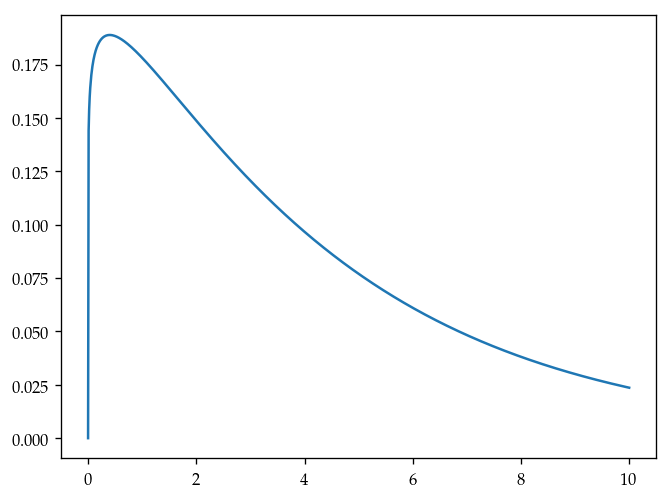

In [88]:
σdistr = Gamma(1.1, 4.0)
xx = range(0, stop=10, length=1000)
plt.plot(xx, pdf.(σdistr, xx))
;

In [43]:
# simulate homoscedastic data under the null hypothesis,
# 200 samples for each group
# where X, Y ~ Normal(0, 2²) and the noise is iid Normal(0, 0.8²).
# Then run the three tests and return the three p-values.
@time KS.sim_tests(Normal(0,2), Normal(0,2), σdistr, 200)

  2.988064 seconds (9.34 M allocations: 220.793 MiB, 0.93% gc time)


(0.7920130315089249, 0.675, 0.715)

The Fourier deconvolution is slow, and for the doubly deconvolved test we need to perform it for every bootstrap sample, so each simulation takes a while (approx. 3 seconds).

# Power under the null

In [52]:
@time for _ in 1:3
    KS_pval, deconvKS_pval, deconv2_pval = KS.sim_tests(
        Normal(0,2), Normal(0,2), # F_X and F_Y are the same
        σdistr, 200)
end

  9.386351 seconds (27.62 M allocations: 656.178 MiB, 1.56% gc time)


In [53]:
@time Threads.@threads for _ in 1:3
    KS_pval, deconvKS_pval, deconv2_pval = KS.sim_tests(
        Normal(0,2), Normal(0,2), # F_X and F_Y are the same
        σdistr, 200)
end

  3.448356 seconds (25.35 M allocations: 597.069 MiB, 7.31% gc time)


In [54]:
nsims = 300
null_KS_arr       = Vector{Float64}(undef, nsims)
null_deconvKS_arr = Vector{Float64}(undef, nsims)
null_deconv2_arr  = Vector{Float64}(undef, nsims)
;
@time Threads.@threads for isim in 1:nsims
    KS_pval, deconvKS_pval, deconv2_pval = KS.sim_tests(
        Normal(0,2), Normal(0,2), # F_X and F_Y are the same
        σdistr, 200)
    null_KS_arr[isim] = KS_pval
    null_deconvKS_arr[isim] = deconvKS_pval
    null_deconv2_arr[isim] = deconv2_pval
end

356.184045 seconds (2.36 G allocations: 55.455 GiB, 2.63% gc time)


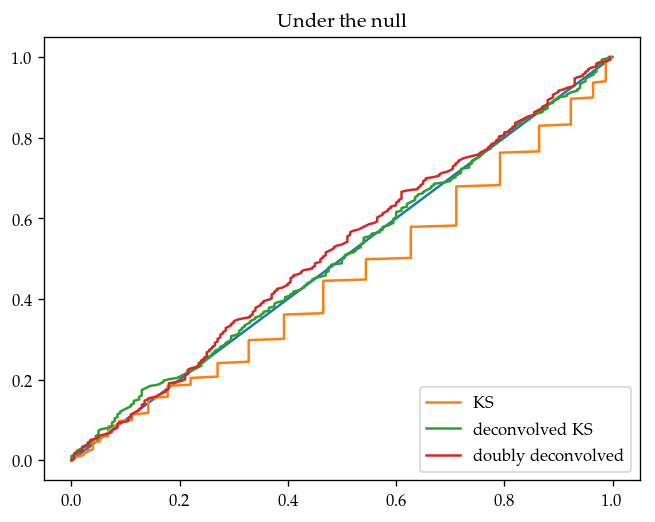

PyObject Text(0.5, 1.0, 'Under the null')

In [89]:
plt.plot([0,1], [0,1])
plot_ecdf(null_KS_arr, label="KS")
plot_ecdf(null_deconvKS_arr, label="deconvolved KS")
plot_ecdf(null_deconv2_arr, label="doubly deconvolved")
plt.legend(loc="lower right")
plt.title("Under the null")

In [56]:
@printf("Power of classical     KS test under the null: %.3f ± %.3f\n", estimate_power(null_KS_arr)...)
@printf("Power of singly-deconv KS test under the null: %.3f ± %.3f\n", estimate_power(null_deconvKS_arr)...)
@printf("Power of doubly-deconv KS test under the null: %.3f ± %.3f\n", estimate_power(null_deconv2_arr)...)

Power of classical     KS test under the null: 0.047 ± 0.012
Power of singly-deconv KS test under the null: 0.077 ± 0.015
Power of doubly-deconv KS test under the null: 0.063 ± 0.014


The above simply shows that all three tests are valid.

# Choosing alternative

The alternative will simply be that:
\begin{equation}
\begin{split}
    X & \sim \mathcal{N}(0, 2^2) \text{, and}\\
    Y & \sim \mathcal{N}(\mu, 2^2)\,.
\end{split}
\end{equation}
The purpose of this section is to choose $\mu$ so the power
of the KS test is somewhere in the range 0.8-0.95,
so that we can easily pick up differences in power
between the three tests in a reasonable scenario.

In [73]:
null_KS = [KS.sim_KS(Normal(0,2), Normal(0,2),   σdistr, 200) for _ in 1:10000]
alt1_KS = [KS.sim_KS(Normal(0,2), Normal(1.0,2), σdistr, 200) for _ in 1:10000]
alt2_KS = [KS.sim_KS(Normal(0,2), Normal(1.3,2), σdistr, 200) for _ in 1:10000]
alt3_KS = [KS.sim_KS(Normal(0,2), Normal(1.5,2), σdistr, 200) for _ in 1:10000]
;

In [74]:
mean(null_KS .<= 0.05)

0.0398

In [75]:
mean(alt1_KS .<= 0.05)

0.5874

In [76]:
mean(alt2_KS .<= 0.05)

0.8151

In [77]:
mean(alt3_KS .<= 0.05)

0.908

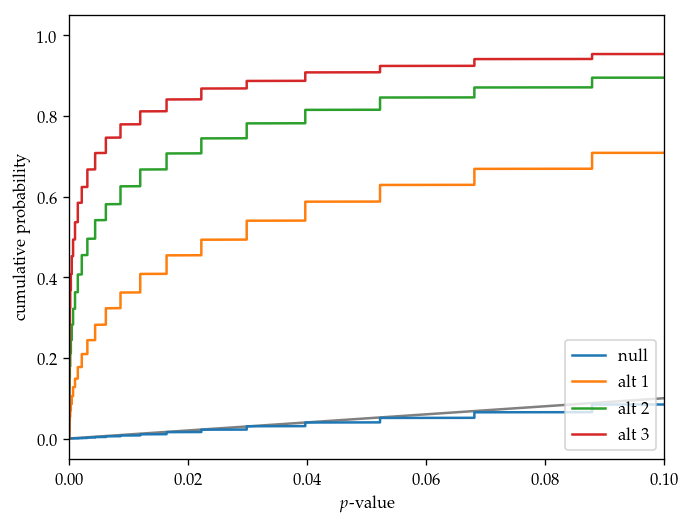

In [91]:
plt.plot([0, 1], [0, 1], color="grey")
plot_ecdf(null_KS, label="null")
plot_ecdf(alt1_KS, label="alt 1")
plot_ecdf(alt2_KS, label="alt 2")
plot_ecdf(alt3_KS, label="alt 3")
plt.legend(loc="lower right")
plt.xlim(0,0.1)
plt.xlabel(L"$p$-value")
plt.ylabel("cumulative probability")
;

We will choose the alternative to have $Y \sim \mathcal{N}(0.8, 2)$, under which the power of the classical KS test is 0.8, leaving plenty of room on either side for the other tests to show their worth.

# Power under the alternative

In [84]:
nsims = 3000
alt_KS_arr       = Vector{Float64}(undef, nsims)
alt_deconvKS_arr = Vector{Float64}(undef, nsims)
alt_deconv2_arr  = Vector{Float64}(undef, nsims)
;
@time Threads.@threads for isim in 1:nsims
    KS_pval, deconvKS_pval, deconv2_pval = KS.sim_tests(
        Normal(0,2), Normal(1.3,2), # F_X and F_Y are different
        σdistr, 200)
    alt_KS_arr[isim] = KS_pval
    alt_deconvKS_arr[isim] = deconvKS_pval
    alt_deconv2_arr[isim] = deconv2_pval
end

3317.450835 seconds (25.56 G allocations: 593.592 GiB, 5.69% gc time)


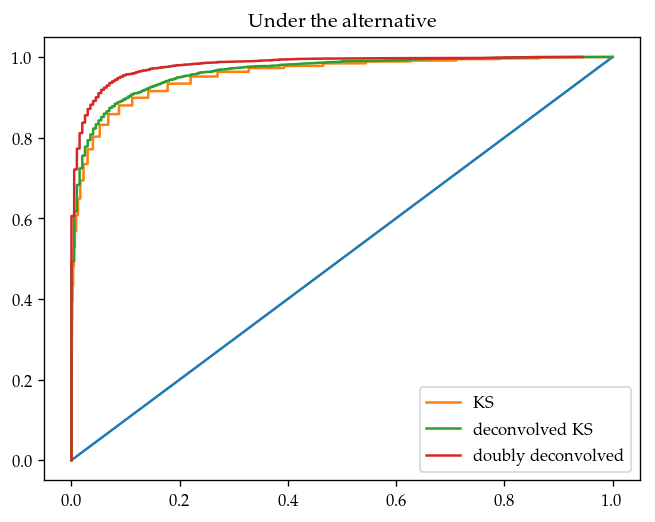

PyObject Text(0.5, 1.0, 'Under the alternative')

In [90]:
plt.plot([0,1], [0,1])
plot_ecdf(alt_KS_arr, label="KS")
plot_ecdf(alt_deconvKS_arr, label="deconvolved KS")
plot_ecdf(alt_deconv2_arr, label="doubly deconvolved")
plt.legend(loc="lower right")
plt.title("Under the alternative")

In [86]:
@printf("Power of classical     KS test under the altv: %.3f ± %.3f\n", estimate_power(alt_KS_arr)...)
@printf("Power of singly-deconv KS test under the altv: %.3f ± %.3f\n", estimate_power(alt_deconvKS_arr)...)
@printf("Power of doubly-deconv KS test under the altv: %.3f ± %.3f\n", estimate_power(alt_deconv2_arr)...)

Power of classical     KS test under the altv: 0.802 ± 0.007
Power of singly-deconv KS test under the altv: 0.843 ± 0.007
Power of doubly-deconv KS test under the altv: 0.910 ± 0.005


# Conclusion

First of all, all tests seem to be valid under the null. If anything, the classical KS test seems to be conservative.

There appears to be no significant change in power going from the classical KS test to the singly deconvolved KS test.
This is similar to what we observed in the homoscedastic case.
The reasoning is that this test is simply a Monte Carlo version of the classical KS test,
replacing analytical results based on asymptotics.


In the case of the doubly deconvolved test, there is a significant increase in power!
Under the alternative, the power goes up from 0.833 to 0.927.
This confirms the intuition that the double deconvolutions will give greater power
in cases of high heteroscedasticity.
In the homoscedastic case, we saw a *loss* of power.
Keep in mind that this uses the Fourier deconvolution, with an arbitrary number chosen for the bandwidth.
With better choice of bandwidth, or better deconvolution method, I'm hoping that the power loss will be lessened in the homoscedastic case, and that the power gain in the heteroscedastic case will be boosted.